In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('jaq', 1, 2) # animal, day, epoch

In [4]:
from src.load_data import make_track_graph

track_graph, center_well_id = make_track_graph()

In [45]:
place_bin_size = 2.0
edge_order = [6, 5, 3, 8, 7, 4, 2, 0, 1]
edge_spacing = 15

In [52]:
from src.load_data import convert_linear_distance_to_linear_position
from scipy.interpolate import interp1d
import networkx as nx

track_graph1 = track_graph.copy()
n_nodes = len(track_graph.nodes)

for edge_ind, (node1, node2) in enumerate(track_graph.edges):
    node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
    node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
    
    edge_size = np.linalg.norm(
        [(node2_x_pos - node1_x_pos), (node2_y_pos - node1_y_pos)])
    n_bins = 2 * np.ceil(edge_size / place_bin_size).astype(np.int) + 1

    f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
    
    xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
    xy = np.stack((xnew, f(xnew)), axis=1)
    dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)
    
    new_node_ids = n_nodes + np.arange(len(dist_between_nodes))
    nx.add_path(track_graph1, [node1, *new_node_ids, node2], distance=dist_between_nodes[0])
    track_graph1.remove_edge(node1, node2)
    for id, pos in zip(new_node_ids, xy):
        track_graph1.nodes[id]['pos'] = pos
        track_graph1.nodes[id]['track_segment_id'] = edge_ind
    track_graph1.nodes[node1]['track_segment_id'] = edge_ind
    track_graph1.nodes[node2]['track_segment_id'] = edge_ind
    n_nodes = len(track_graph1.nodes)

In [53]:
distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))

node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
track_segment_id = np.array([ids[node_id] for node_id in node_ids])
linear_distance = np.array(linear_distance)

linear_position = convert_linear_distance_to_linear_position(
        linear_distance, track_segment_id, edge_order, spacing=edge_spacing)

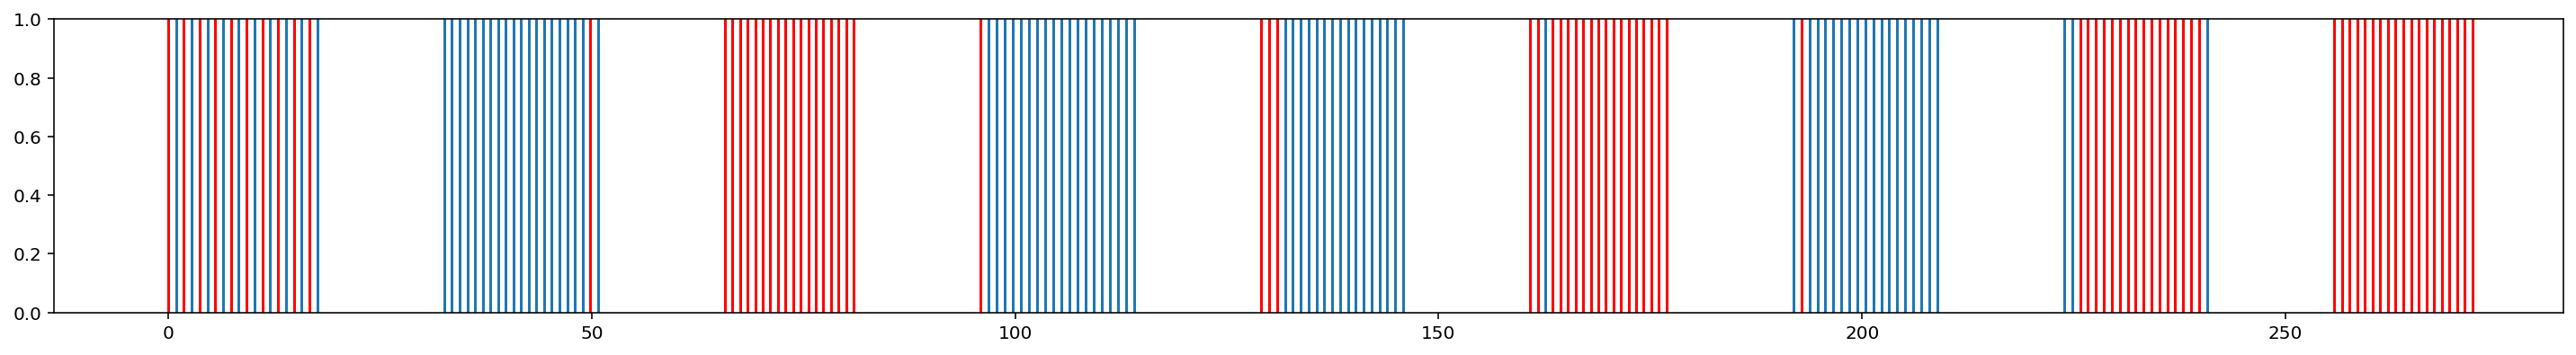

In [58]:
plt.figure(figsize=(25, 3))

for pos in linear_position[1::2]:
    plt.axvline(pos)
    
for pos in linear_position[::2]:
    plt.axvline(pos, color='red')

In [ ]:
from scipy.stats import multivariate_normal
from src.load_data import convert_linear_distance_to_linear_position
from scipy.ndimage import label
from replay_trajectory_classification.state_transition import _normalize_row_probability

EDGE_ORDER = [6, 5, 3, 8, 7, 4, 2, 0, 1]
    
    
def make_state_transition(track_graph, place_bin_centers, center_well_id,
                          is_track_interior, edge_order, edge_spacing,
                          replay_speed=1, movement_var=64):
    
    track_graph1 = track_graph.copy()
    n_nodes = len(track_graph.nodes)
    n_bins = 100

    for edge_ind, (node1, node2) in enumerate(track_graph.edges):
        node1_x_pos, node1_y_pos = track_graph.nodes[node1]['pos']
        node2_x_pos, node2_y_pos = track_graph.nodes[node2]['pos']
        f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
        xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)    
        xy = np.stack((xnew, f(xnew)), axis=1)
        dist = np.linalg.norm(np.diff(xy, axis=0), axis=1)
        new_node_ids = n_nodes + np.arange(len(dist))
        nx.add_path(track_graph1, [node1, *new_node_ids, node2], distance=dist[0])
        track_graph1.remove_edge(node1, node2)
        for id, pos in zip(new_node_ids, xy):
            track_graph1.nodes[id]['pos'] = pos
            track_graph1.nodes[id]['track_segment_id'] = edge_ind
        track_graph1.nodes[node1]['track_segment_id'] = edge_ind
        track_graph1.nodes[node2]['track_segment_id'] = edge_ind
        n_nodes = len(track_graph1.nodes)
        
    distance = dict(nx.all_pairs_dijkstra_path_length(track_graph1, weight='distance'))
    
    node_ids, linear_distance = list(zip(*distance[center_well_id].items()))
    ids = nx.get_node_attributes(track_graph1, 'track_segment_id')
    track_segment_id = np.array([ids[node_id] for node_id in node_ids])
    linear_distance = np.array(linear_distance)

    linear_position = convert_linear_distance_to_linear_position(
            linear_distance, track_segment_id, edge_order, spacing=edge_spacing)

    close_ind = np.argmin(np.abs(linear_position - place_bin_centers), axis=1)

    state_transition = np.zeros((place_bin_centers.size, place_bin_centers.size))
    gaussian = multivariate_normal(
            mean=0, cov=movement_var * replay_speed)

    for bin_ind1, node_ind1 in enumerate(close_ind):
        for bin_ind2, node_ind2 in enumerate(close_ind):
            state_transition[bin_ind1, bin_ind2] = gaussian.pdf(
                    distance[node_ids[node_ind1]][node_ids[node_ind2]])

    state_transition[~is_track_interior] = 0
    state_transition[:, ~is_track_interior] = 0
    
    state_transition = _normalize_row_probability(state_transition)
    node_to_bin = np.array([node_ids[ind] for ind in close_ind])
    
    return state_transition, track_graph1, node_to_bin